In [34]:
import json
import collections 

import osmnx as ox
from osmnx import distance as oxdist
import matplotlib.pyplot as plt

MultiDiGraph with 2011 nodes and 3833 edges


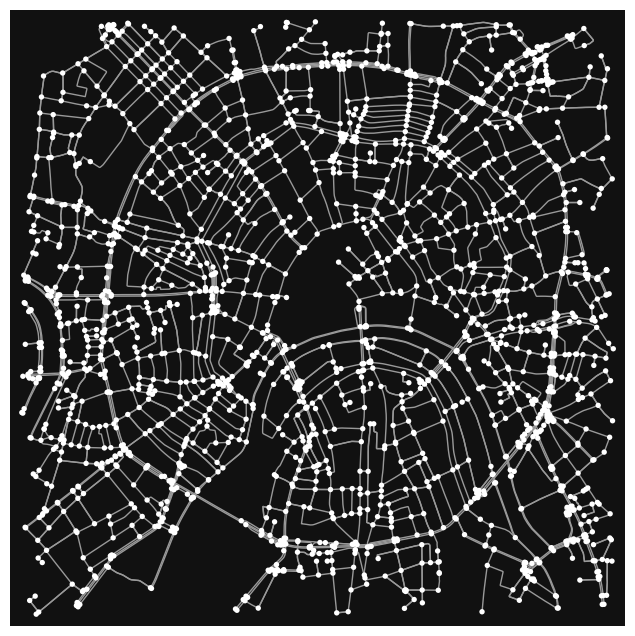

In [35]:
# Extract city graph (for drivable roads)
city_name = "Moscow, Russia"

point = ox.geocode(city_name)
G = ox.graph_from_point(point, dist=3000, network_type="drive")

print(G)
ox.plot_graph(G) 
plt.show()


Map Data is usually stored in the WGS84 format (World Geodetic System 1984) which describes coordinates via latidude and longitude e.g.
$$( \underbrace{52.5163° N}_{\text{Latitude North}}, \underbrace{13.3777° E}_{\text{Longitude East}}, \underbrace{34 m}_{\text{Height}})$$


<p align="center" style="background-color: #4d4a43; padding: 10px;">
  <img src="https://www.maptive.com/wp-content/uploads/2021/01/Latitude_and_Longitude_of_the_Earth.svg" alt="Latitude and Longitude">
</p>
 
As these are descriptions of angles on the earth's ellipsoid, they are not directly suitable for simple distance calculations:
Therefore, for geometric computations (like distances, areas, buffering), it is easier to work with a CRS (Coordinate Reference System) that projects the curved surface of the earth onto a flat plane.

A common choice is UTM (Universal Transverse Mercator), which expresses positions in meters within a given zone. This way, distances between points can be obtained by straightforward Euclidean formulas.

In [36]:
# Convert from WGS84 to CRS via UTM
G = ox.project_graph(G) 
oxdist.add_edge_lengths(G) 


nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

nodes = nodes_gdf.reset_index()[["osmid", "x", "y"]].rename(columns={"osmid": "id"})
edges = edges_gdf.reset_index()[["u", "v", "length"]]
adjacencies = collections.defaultdict(dict)


for u, v, data in G.edges(data=True):
    w = data.get("length", 1.0)
    # normalize IDs to str for JSON
    u, v = str(u), str(v)
    adjacencies[u][v] = min(w, adjacencies[u].get(v, w))
    adjacencies[v][u] = min(w, adjacencies[v].get(u, w))

# Make edges undirected
edges_set = {}
for u in adjacencies:
    for v, w in adjacencies[u].items():
        key = tuple(sorted((u, v)))
        if key not in edges_set or w < edges_set[key]:
            edges_set[key] = w
edges_out = [{"u": u, "v": v, "length": float(w)} for (u, v), w in edges_set.items()]

# --- nodes ---
nodes_out = (
    nodes.reset_index()
         .rename(columns={"index": "id"})
         .assign(
             x=lambda df: df["x"].astype(float),
             y=lambda df: df["y"].astype(float)
         )
         .to_dict(orient="records")
)


# --- adjacencies ---
adj_out = {u: [[v, float(w)] for v, w in nbrs.items()] for u, nbrs in adjacencies.items()}

with open(f"{city_name}.json", "w") as f:
    json.dump(
        {"nodes": nodes_out, "edges": edges_out, "adjacencies": adj_out},
        f,
        separators=(",", ":")
    )


/var/folders/0q/xwqk_gnd3kv9_45v8klfklnw0000gn/T/ipykernel_57632/1858223289.py:31: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  nodes.reset_index()
